In [145]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import string
import numpy as np
import re

In [110]:
class Perceptron(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.fc1  = nn.Linear(input_dim, 1)
  
  def forward(self, x_in):
    return torch.sigmoid(self.fc1(x_in)).squeeze()

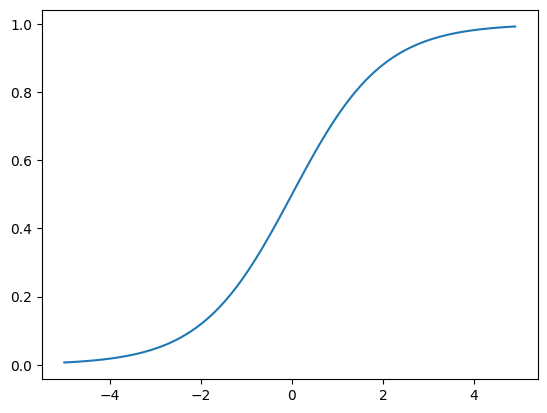

In [111]:
x = torch.arange(-5, 5, 0.1)
y = torch.sigmoid(x)
plt.plot(x, y)
plt.show();

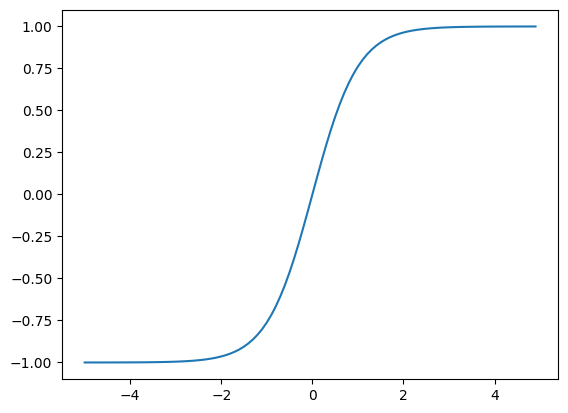

In [112]:
x = torch.arange(-5, 5, 0.1)
y = torch.tanh(x)
plt.plot(x, y)
plt.show()

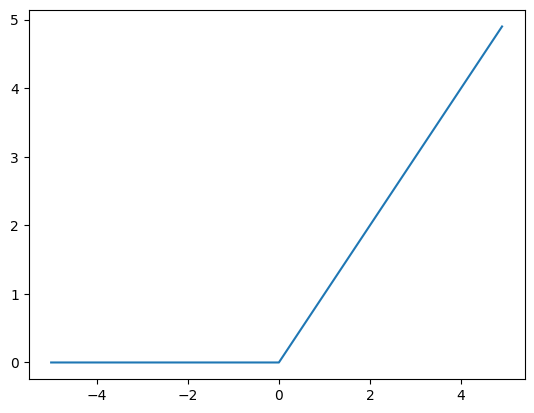

In [113]:
y = torch.relu(x)
plt.plot(x, y)
plt.show()

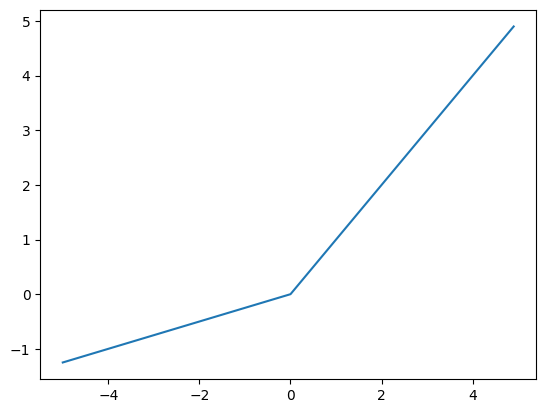

In [114]:
prelu = torch.nn.PReLU(num_parameters = 1)
plt.plot(x.numpy(), prelu(x).detach())
plt.show()

In [115]:
softmax = torch.nn.Softmax(dim = 1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output) # the 'probabilities' of the inputs
print(torch.sum(y_output, dim = 1)) # sum is always 1

tensor([[ 0.0979,  0.5070, -1.3450]])
tensor([[0.3647, 0.5491, 0.0862]])
tensor([1.])


In [116]:
mse_loss = torch.nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad = True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
print(loss)

tensor(0.7826, grad_fn=<MseLossBackward0>)


In [117]:
ce_loss = torch.nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad = True)
targets = torch.randn(3, 5)
loss = ce_loss(outputs, targets)
print(loss)

tensor(-3.3819, grad_fn=<DivBackward1>)


In [118]:
bce_loss = torch.nn.BCELoss() # binary cross entropy loss
sigmoid = torch.nn.Sigmoid()
outputs = sigmoid(torch.randn(4, 1, requires_grad = True))
targets = torch.tensor([1, 0, 1, 0], dtype=torch.float32).view(4, 1) # datatype needs to be torch.float32 for this to work
loss = bce_loss(outputs, targets)
print(outputs)
print(targets)
print(loss)

tensor([[0.4345],
        [0.0752],
        [0.2887],
        [0.4089]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [1.],
        [0.]])
tensor(0.6699, grad_fn=<BinaryCrossEntropyBackward0>)


In [119]:
import torch.nn as nn
import torch.optim as optim

input_dim = 2
lr = 1e-3
perceptron = Perceptron(input_dim = input_dim)
adam = optim.Adam(params = perceptron.parameters(), lr = lr)

Four steps to do training for each epoch (in PyTorch):

1. Get the data
2. Zero out the gradient (using `model.zero_grad()`)
3. Compute the forward pass using whatever model you have (using `model(x_data)`)
4. Compute the loss value using whatever loss function you have (using `mse_loss(output, target)`)
5. Propagate the loss signal backward (using `loss.backward()`)
6. Trigger the optimizer to perform one update (using `optim.step()`)

In [120]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
  def __init__(self, review_df, vectorizer):
    self.review_df = review_df
    self._vectorizer = vectorizer

    self.train_df = self.review_df[self.review_df["split"] == "train"]
    self.train_size = len(self.train_df)

    self.val_df = self.review_df[self.review_df["split"] == "val"]
    self.val_size = len(self.val_df)

    self.test_df = self.review_df[self.review_df["split"] == "test"]
    self.test_size = len(self.test_df)

    self._lookup_dict = {
      "train": (self.train_df, self.train_size),
      "val": (self.val_df, self.val_size),
      "test": (self.test_df, self.test_size)
    }

    self.set_split("train")

  @classmethod
  def load_dataset_and_make_vectorizer(cls, review_csv):
    review_df = pd.read_csv(review_csv)
    return cls(review_df, ReviewVectorizer.from_dataframe(review_df))

  def get_vectorizer(self):
    return self._vectorizer

  def set_split(self, split = "train"):
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]
  
  def __len__(self):
    return self._target_size

  def __getitem__(self, index):
    row = self._target_df.iloc[index]
    review_vector = self._vectorizer.vectorize(row.review)
    rating_index = self._vectorizer.rating_vocab.lookup_token(row.rating)

    return {"x_data": review_vector, "y_data": rating_index}
  
  def get_num_batches(self, batch_size):
    return len(self)//batch_size

Now we need to make at least three things: a `Vocabulary`, a `Vectorizer` (in this case, a `ReviewVectorizer`), and a `DataLoader`.

- The `Vocabulary` class will encapsulate the token-to-index and index-to-token conversion, as well as handle unknown tokens with `UNK`.
- The `ReviewVectorizer` class will in turn, encapsulate the `Vocabulary` class by giving converting tokens to integers (main functionality is in the `ReviewVectorizer::vectorize()` method)
- The `DataLoader` class just groups datapoints together in minibatches so that training can run more efficiently

In [121]:
class Vocabulary():
  def __init__(self, token_to_idx = None, add_unk = True, unk_token = "<UNK>"):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx
    self._idx_to_token = {idx: token for token, idx in token_to_idx.items()}

    self._add_unk = add_unk
    self._unk_token = unk_token
    self.unk_idx = -1
    if add_unk:
      self.unk_idx = self.add_token(unk_token)

  def to_serializable(self):
    return {
      "token_to_idx": self._token_to_idx,
      "add_unk": self._add_unk,
      "unk_token": self._unk_token
    }

  @classmethod
  def from_serializable(cls, contents):
    return cls(**contents)
  
  def add_token(self, token):
    if token in self._token_to_idx:
      index = self._token_to_idx[token]
    else:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token

  def lookup_token(self, token):
    if self._add_unk:
      return self._token_to_idx.get(token, self.unk_idx)
    else:
      return self._token_to_idx[token]

  def lookup_index(self, index):
    if index not in self._idx_to_token:
      raise KeyError(f"The index {index} is not found in the vocabulary.")
    else:
      return self._idx_to_token[index]
  
  def __str__(self):
    return "<Vocabulary(size = %d)" % len(self)
  
  def __len__(self):
    return len(self._token_to_idx)

The `cls` argument in every method with the `@classmethod` tag is actually just allowing for the method to be a factory method. Hence, instead of using the basic format of `ReviewVectorizer(...)` to instantiate an object, we can use `ReviewVectorizer::from_dataframe()` to do it. 

In [122]:
class ReviewVectorizer():
  def __init__(self, review_vocab, rating_vocab):
    self.review_vocab = review_vocab
    self.rating_vocab = rating_vocab
  
  def vectorize(self, review):
    one_hot = np.zeros(len(self.review_vocab), dtype = np.float32)
    for token in review.split(" "):
      if token not in string.punctuation:
        one_hot[self.review_vocab.lookup_token(token)] = 1    
    return one_hot
  
  @classmethod
  def from_dataframe(cls, review_df, cutoff = 25):
    review_vocab = Vocabulary(add_unk = True)
    rating_vocab = Vocabulary(add_unk = False)

    # add ratings
    for rating in sorted(set(review_df.rating)):
      rating_vocab.add_token(rating)
    
    word_counts = Counter()
    for review in review_df.review:
      for word in review.split(" "):
        if word not in string.punctuation:
          word_counts[word] += 1
      
    for word, count in word_counts.items():
      if count > cutoff:
        review_vocab.add_token(word)
    
    return cls(review_vocab, rating_vocab)
  
  @classmethod
  def from_serializable(cls, contents):
    review_vocab = Vocabulary.from_serializable(contents["review_vocab"])
    rating_vocab = Vocabulary.from_serializable(contents["rating_vocab"])

    return cls(review_vocab, rating_vocab)
  
  def to_serializable(self):
    return {
      "review_vocab": self.review_vocab.to_serializable(),
      "rating_vocab": self.rating_vocab.to_serializable()
    }

In [123]:
from torch.utils.data import DataLoader
def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
  dataloader = DataLoader(
      dataset=dataset, batch_size=batch_size,
      shuffle=shuffle, drop_last=drop_last
  )

  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = tensor.to(device)
    yield out_data_dict


Importing `torch.nn.functional` as `F` just allows us to use common functions like `F.sigmoid`.

In [124]:
import torch.nn as nn
import torch.nn.functional as F


class ReviewClassifier(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.fc1 = nn.Linear(in_features=num_features, out_features=1)

  def forward(self, x_in, apply_sigmoid=False):
    y_out = self.fc1(x_in).squeeze()
    if apply_sigmoid:
      y_out = F.sigmoid(y_out)
    return y_out


`Namespace` is just a way for you to not clutter the main namespace of whatever program you have

In [125]:
from argparse import Namespace

args = Namespace(
    frequency_cutoff=25,
    model_state_file='model.pth', review_csv='data/yelp/reviews_with_splits_lite.csv', save_dir='model_storage/ch3/yelp/', vectorizer_file='vectorizer.json',
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
)


In [127]:
import torch.optim as optim
from collections import Counter
def make_train_state(args):
    return {
        'epoch_index': 0, 'train_loss': [],
        'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': 1, 'test_acc': 1
    }

train_state = make_train_state(args)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features = len(vectorizer.review_vocab))
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr = args.learning_rate)


In [130]:

for epoch_index in range(args.num_epochs):
    train_state["epoch_index"] = epoch_index

    dataset.set_split("train")
    batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)

    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in = batch_dict["x_data"].float())

        loss = loss_func(y_pred, batch_dict["y_data"].float())
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        loss.backward()
        optimizer.step()
        # print(y_pred)
        # acc_batch = compute_accuracy(y_pred.detach(), batch_dict["y_data"])
        # running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)

    dataset.set_split("val")
    batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)

    running_loss = 0.0
    running_acc = 0.0
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in = batch_dict["x_data"].float())
        loss = loss_func(y_pred, batch_dict["y_data"].float())

        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # acc_batch = compute_accuracy(y_pred.detach(), batch_dict["y_data"])
        # running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)




In [132]:
dataset.set_split("test")
batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
running_loss = 0.0
classifier.eval() # remember to put this before passing in any data

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(x_in = batch_dict["x_data"].float())
    loss = loss_func(y_pred, batch_dict["y_data"].float())
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)

train_state["test_loss"] = running_loss

In [135]:
print(f"Test Loss: {train_state['test_loss']:.3f}")

Test Loss: 0.681


In [141]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^azAZ.,!?]+", r" ", text) 
    return text


In [149]:
def predict_rating(review, classifier, vectorizer, decision_threshold = 0.5):
    review = preprocess_text(review)
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))

    probability_value = torch.sigmoid(result).item()

    index = 1
    if probability_value < decision_threshold:
        index = 0
    
    return vectorizer.rating_vocab.lookup_index(index)

In [150]:
test_review = "This is a pretty awesome book!"
prediction = predict_rating(test_review, classifier, vectorizer)
print(f"{test_review} --> {prediction}")

This is a pretty awesome book! --> positive
